In [1]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


In [2]:
!ls

gdrive	sample_data


# Change directory to allow imports


As noted above, you should create a Google Drive folder to hold all your assignment files. You will need to add this code to the top of any python notebook you run to be able to import python files from your drive assignment folder (you should change the file path below to be your own assignment folder).

In [3]:
import os
if not os.path.exists("/content/gdrive/My Drive/Colab Notebooks/CS_585_PS2"):
    os.makedirs("/content/gdrive/My Drive/Colab Notebooks/CS_585_PS2")
os.chdir("/content/gdrive/My Drive/Colab Notebooks/CS_585_PS2")

In [4]:
!ls # Check if this is your PS2 folder

baseline_result.png		  Q1_label_predictions.npy
cifar10_arch.png		  Q2_surface_predictions.npy
cifar10.png			  q2_visualization.pdf
cifar10_splits			  taskonomy_resize_128_release
CS585_PS2.ipynb			  upload_steps.png
mp4_q1_plot.png			  visualization_r18.png
point_1_view_6_domain_normal.png  vis_valset.pdf
point_1_view_6_domain_rgb.png


# Set up GPU and PyTorch

First, ensure that your notebook on Colaboratory is set up to use GPU. After opening the notebook on Colaboratory, go to Edit>Notebook settings, select Python 3 under "Runtime type," select GPU under "Hardware accelerator," and save.

Next, install PyTorch:

In [ ]:
!pip3 install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Make sure that pytorch is installed and works with GPU:

In [5]:
import torch
a = torch.Tensor([1]).cuda()
print(a)


tensor([1.], device='cuda:0')


In [6]:
torch.cuda.is_available()

True

In [7]:
# imports and useful functions

from __future__ import print_function
from PIL import Image
import os
import os.path
import numpy as np
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity
import copy
import csv
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path
from tqdm.notebook import tqdm
import sys
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

np.random.seed(111)
torch.cuda.manual_seed_all(111)
torch.manual_seed(111)


class CIFAR10Test(torchvision.datasets.VisionDataset):
    def __init__(self, root, transform=None,
    ):
        super(CIFAR10Test, self).__init__(root, transform=transform)

        image_filename = os.path.join(root, 'cifar10_test_images.npy')
        images = np.load(image_filename)

        assert len(images.shape) == 4
        assert images.shape[0] == 2000
        assert images.shape[1] == 32
        assert images.shape[2] == 32
        assert images.shape[3] == 3

        self.data = images

    def __getitem__(self, index):
        img = self.data[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img

    def __len__(self):
        return len(self.data)


def calculate_accuracy(dataloader, model, is_gpu):
    """ Util function to calculate val set accuracy,
    both overall and per class accuracy
    Args:
        dataloader (torch.utils.data.DataLoader): val set 
        is_gpu (bool): whether to run on GPU
    Returns:
        tuple: (overall accuracy, class level accuracy)
    """    
    correct = 0.
    total = 0.
    predictions = []

    class_correct = list(0. for i in range(TOTAL_CLASSES))
    class_total = list(0. for i in range(TOTAL_CLASSES))

    # Check out why .eval() is important!
    # https://discuss.pytorch.org/t/model-train-and-model-eval-vs-model-and-model-eval/5744/2
    model.eval()

    with torch.no_grad():
      for data in dataloader:
          images, labels,  = data
          if is_gpu:
              images = images.cuda()
              labels = labels.cuda()
          #images, labels, mask, = data
          #images = images.to(device)
          #labels = labels.to(device)
          #mask = mask.to(device)
          outputs = model(Variable(images))
          _, predicted = torch.max(outputs.data, 1)
          predictions.extend(list(predicted.cpu().numpy()))
          total += labels.size(0)
          correct += (predicted == labels).sum()

          c = (predicted == labels).squeeze()
          for i in range(len(labels)):
              label = labels[i]
              class_correct[label] += c[i].cpu()
              class_total[label] += 1

    class_accuracy = 100 * np.divide(class_correct, class_total)
    return 100*correct/total, class_accuracy


def run_secret_test(dataloader, model, is_gpu):
    predictions = []
    model.eval()

    with torch.no_grad():
      for images in dataloader:
          if is_gpu:
              images = images.cuda()
          outputs = model(Variable(images))
          predicted = torch.softmax(outputs, dim=1).cpu().numpy()
          predictions.extend(list(predicted))
        
    return predictions



Training an image classifier
----------------------------

We will do the following steps in order:

1. Load the randomized CIFAR10 training, validation and test datasets using
   torchvision. Use torchvision.transforms to apply transforms on the
   dataset.
2. Define a Convolution Neural Network - BaseNet
3. Define a loss function and optimizer
4. Train the network on training data and check performance on val set.
   Plot train loss and validation accuracies.
5. Try the network on test data and create .npy file for submission to Gradescope

In [8]:
import os
print(os.getcwd())

/content/gdrive/My Drive/Colab Notebooks/CS_585_PS2


In [10]:
# <<TODO>>: Based on the val set performance, decide how many
# epochs are apt for your model.
# ---------
EPOCHS = 50
# ---------

IS_GPU = True
TEST_BS = 256
TOTAL_CLASSES = 10
TRAIN_BS = 32
PATH_TO_CIFAR10 = "cifar10_splits/"
PATH_TO_CIFAR10_TEST = "cifar10_splits/"

1.**Loading CIFAR-10**

We will load the CIFAR-10 dataset with builtin dataset loader from Torchvision. We also created our own train, validation and test splits. You can download them using this link: https://drive.google.com/file/d/1VkiwqowKrNMe6l3wV7-d6FIU3PENpcsI/view?usp=sharing . Upload the file to colab.

We provide a screenshot below on how and wwhere to upload the required data for both questions.

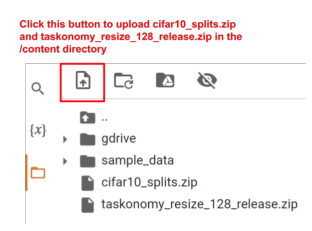

In [ ]:
plt.axis('off')
plt.imshow(Image.open('/content/gdrive/MyDrive/Colab Notebooks/CS_585_PS2/upload_steps.png'))

In [ ]:
!unzip -qqo /content/gdrive/MyDrive/Colab\ Notebooks//cifar10_splits.zip

unzip:  cannot find or open /content/gdrive/MyDrive/Colab Notebooks//cifar10_splits.zip, /content/gdrive/MyDrive/Colab Notebooks//cifar10_splits.zip.zip or /content/gdrive/MyDrive/Colab Notebooks//cifar10_splits.zip.ZIP.


In [11]:
# The output of torchvision datasets are PILImage images of range [0, 1].
# Using transforms.ToTensor(), transform them to Tensors of normalized range
# [-1, 1].


# <<TODO#1>> Use transforms.Normalize() with the right parameters to 
# make the data well conditioned (zero mean, std dev=1) for improved training.
# <<TODO#2>> Try using transforms.RandomCrop() and/or transforms.RandomHorizontalFlip()
# to augment training data.
# After your edits, make sure that test_transform should have the same data
# normalization parameters as train_transform
# You shouldn't have any data augmentation in test_transform (val or test data is never augmented).
# ---------------------
train_transform = transforms.Compose(
      [transforms.RandomCrop(size=32, padding=4),
       transforms.RandomHorizontalFlip(),
       transforms.ToTensor(), 
       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])
test_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])
# ---------------------

#DO NOT CHANGE any line below
train_dataset = torchvision.datasets.CIFAR10(root=PATH_TO_CIFAR10, train=True, download=True, transform=train_transform)
val_dataset = torchvision.datasets.CIFAR10(root=PATH_TO_CIFAR10, train=False, download=False, transform=test_transform)
test_dataset = CIFAR10Test(root=PATH_TO_CIFAR10_TEST, transform=test_transform)

val_dataset.data = np.load("cifar10_splits/cifar10_val_images.npy")
val_dataset.targets = np.load("cifar10_splits/cifar10_val_labels.npy")
test_dataset.data = np.load("cifar10_splits/cifar10_test_images.npy")

print("train_dataset data shape: ", np.array(train_dataset.data).shape)
print("train_dataset labels shape: ", np.array(train_dataset.targets).shape)
print()
print("val_dataset data shape: ", np.array(val_dataset.data).shape)
print("val_dataset labels shape:", np.array(val_dataset.targets).shape)
#print("train_dataset data shape: ", np.array(test_dataset.data).shape)
#print("train_dataset labels shape: ", np.array(test_dataset.targets).shape)

# check for Dataloader function: https://pytorch.org/docs/stable/data.html
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BS, shuffle=True, num_workers=2, drop_last=True)  #DO NOT CHANGE
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=TEST_BS, shuffle=False, num_workers=2, drop_last=False) #DO NOT CHANGE
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BS, shuffle=False, num_workers=2, drop_last=False) #DO NOT CHANGE

# The 10 classes for FashionMNIST
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Files already downloaded and verified
train_dataset data shape:  (50000, 32, 32, 3)
train_dataset labels shape:  (50000,)

val_dataset data shape:  (8000, 32, 32, 3)
val_dataset labels shape: (8000,)


2.**Visualize CIFAR-10**

We will visualize some random images from the CIFAR-10 dataset.

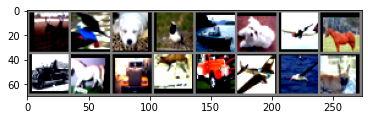

horse  bird   dog  bird  ship   dog airplane horse truck horse truck  deer truck airplane  bird   dog


In [12]:
# Let us show some of the training images, for fun.
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:16]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

3.**Define a Convolution Neural Network**

Implement the BaseNet exactly. BaseNet consists of two convolutional modules (conv-relu-maxpool) and two linear layers. The precise architecture is defined below:

| Layer No.   | Layer Type  | Kernel Size | Input Dim   | Output Dim  | Input Channels | Output Channels |
    | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
    | 1 | conv2d | 5 | 32 | 28 | 3 | 6 |
    | 2 | relu | - | 28 | 28 | 6 | 6 |
    | 3 | maxpool2d | 2 | 28 | 14 | 6 | 6 |
    | 4 | conv2d | 5 | 14 | 10 | 6 | 16 |
    | 5 | relu | - | 10 | 10 | 16 | 16 |
    | 6 | maxpool2d | 2 | 10 | 5 | 16 | 16 |
    | 7 | linear | - | 1 | 1 | 400 | 200 |
    | 8 | relu | - | 1 | 1 | 200 | 200 |
    | 9 | linear | - | 1 | 1 | 200 | 10 |

In [13]:
class BaseNet(nn.Module):
    def __init__(self, num_classes=10):
        super(BaseNet, self).__init__()
        self.conv1=nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1= nn.BatchNorm2d(16)
        self.conv2=nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2= nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3= nn.BatchNorm2d(64)
        self.conv31 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn31= nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn4= nn.BatchNorm2d(128)
        self.conv41 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn41= nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn5= nn.BatchNorm2d(256)
        self.conv51 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn51= nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6= nn.BatchNorm2d(512)
        self.conv61 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn61= nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(524288, 10)
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.relu(self.bn3(self.conv3(out)))
        out = F.relu(self.bn31(self.conv31(out)))
        out = F.relu(self.bn4(self.conv4(out)))
        out = F.relu(self.bn41(self.conv41(out)))
        out = F.relu(self.bn5(self.conv5(out)))
        out = F.relu(self.bn51(self.conv51(out)))
        out = F.relu(self.bn6(self.conv6(out)))
        out = F.relu(self.bn61(self.conv61(out)))
        #print(out.shape)
        out = out.view(-1,524288)
        out= self.fc1(out)
        return out

net = BaseNet()

# Test your BaseNet with some random input
dummy_input = torch.rand((1, 3, 32, 32))
output = net(dummy_input)
assert output.shape == torch.Size([1, 10])

# For training on GPU, we need to transfer net and data onto the GPU
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
if IS_GPU:
    net = net.cuda()

In [ ]:
########################################################################
# We provide a basic network that you should understand, run and
# eventually improve
# <<TODO>> Add more conv layers
# <<TODO>> Add more fully connected (fc) layers
# <<TODO>> Add regularization layers like Batchnorm.
#          nn.BatchNorm2d after conv layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm2d
#          nn.BatchNorm1d after fc layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm1d
# This is a good resource for developing a CNN for classification:
# http://cs231n.github.io/convolutional-networks/#layers

import torch.nn as nn
import torch.nn.functional as F
class ResidualBlock(nn.Module):
    def __init__(self, input_planes, planes, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.red = nn.Sequential()
        if stride != 1 or input_planes != planes:
            self.red = nn.Sequential(
                nn.Conv2d(input_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out=self.conv1(x)
        out=self.bn1(out)
        out=F.relu(out)
        out= self.conv2(out)
        out = self.bn2(out)
        out += self.red(x)
        out = F.relu(out)
        return out

class BaseNet(nn.Module):
    def __init__(self, num_classes=10):
        super(BaseNet, self).__init__()
        #self.in_planes=64
        self.conv1=nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1= nn.BatchNorm2d(16)
        self.conv2=nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2= nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3= nn.BatchNorm2d(64)
        

        self.block1 = nn.Sequential(
            ResidualBlock(64, 64),
            ResidualBlock(64, 64)
        )
        self.block2 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128)
        )
        self.block3 = nn.Sequential(
            ResidualBlock(128, 256, stride=2),
            ResidualBlock(256, 256)
        )
        self.block4 = nn.Sequential(
            ResidualBlock(256, 512, stride=2),
            ResidualBlock(512, 512)
        )

        self.linear = nn.Linear(512, num_classes)
        #self.dropout= nn.Dropout(0.25)

    def forward(self, out):
        out = F.relu(self.bn1(self.conv1(out)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.relu(self.bn3(self.conv3(out)))
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        #out = self.block5(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        #out = self.dropout(out)
        return out
# Create an instance of the nn.module class defined above:
net = BaseNet()

# Test your BaseNet with some random input
dummy_input = torch.rand((1, 3, 32, 32))
output = net(dummy_input)
assert output.shape == torch.Size([1, 10])

# For training on GPU, we need to transfer net and data onto the GPU
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
if IS_GPU:
    net = net.cuda()


In [14]:
# TODO: paste output in your report
print(net)

BaseNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv31): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn31): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv41): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4

4.**Define a loss function and optimizer**

In [15]:
########################################################################
# Here we use Cross-Entropy loss and SGD with momentum.
# The CrossEntropyLoss criterion already includes softmax within its
# implementation. That's why we don't use a softmax in our model
# definition.

import torch.optim as optim
criterion = nn.CrossEntropyLoss()

# Tune the learning rate.
# See whether the momentum and weight decay is useful or not
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0)



5.**Train the model**

In [ ]:
########################################################################
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize. We evaluate the validation accuracy at each
# epoch and plot these values over the number of epochs
# Nothing to change here
# -----------------------------
plt.ioff()
fig = plt.figure()
train_loss_over_epochs = []
val_accuracy_over_epochs = []

for epoch in tqdm(range(EPOCHS), total=EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        if IS_GPU:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #outputs = torch.argmax(outputs, dim=1)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    
    # Normalizing the loss by the total number of train batches
    running_loss/=len(trainloader)
    print('[%d] loss: %.3f' %
          (epoch + 1, running_loss))

    # Scale of 0.0 to 100.0
    # Calculate validation set accuracy of the existing model
    val_accuracy, val_classwise_accuracy = \
        calculate_accuracy(valloader, net, IS_GPU)
    print('Accuracy of the network on the val images: %d %%' % (val_accuracy))
    #scheduler.step(running_loss)
    # # Optionally print classwise accuracies
    # for c_i in range(TOTAL_CLASSES):
    #     print('Accuracy of %5s : %2d %%' % (
    #         classes[c_i], 100 * val_classwise_accuracy[c_i]))

    train_loss_over_epochs.append(running_loss)
    val_accuracy_over_epochs.append(val_accuracy.cpu())
# -----------------------------


# Plot train loss over epochs and val set accuracy over epochs
# Nothing to change here
# -------------
plt.subplot(2, 1, 1)
plt.ylabel('Train loss')
plt.plot(np.arange(EPOCHS), train_loss_over_epochs, 'k-')
plt.title('train loss and val accuracy')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.arange(EPOCHS), val_accuracy_over_epochs, 'b-')
plt.ylabel('Val accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)
plt.savefig("mp4_q1_plot.png")
plt.close(fig)
print('Finished Training')
# -------------

  0%|          | 0/50 [00:00<?, ?it/s]

[1] loss: 3.831
Accuracy of the network on the val images: 40 %
[2] loss: 1.716
Accuracy of the network on the val images: 43 %
[3] loss: 1.610
Accuracy of the network on the val images: 45 %
[4] loss: 1.549
Accuracy of the network on the val images: 47 %
[5] loss: 1.499
Accuracy of the network on the val images: 48 %
[6] loss: 1.448
Accuracy of the network on the val images: 53 %
[7] loss: 1.407
Accuracy of the network on the val images: 53 %
[8] loss: 1.367
Accuracy of the network on the val images: 55 %
[9] loss: 1.330
Accuracy of the network on the val images: 56 %
[10] loss: 1.288
Accuracy of the network on the val images: 58 %
[11] loss: 1.236
Accuracy of the network on the val images: 59 %
[12] loss: 1.186
Accuracy of the network on the val images: 62 %
[13] loss: 1.129
Accuracy of the network on the val images: 64 %
[14] loss: 1.078
Accuracy of the network on the val images: 65 %


6.**Evaluate the validation accuracy of your final model**

In [ ]:
val_accuracy, val_classwise_accuracy = \
        calculate_accuracy(valloader, net, IS_GPU)
print('Accuracy of the final network on the val images: %.1f %%' % (val_accuracy))

# Optionally print classwise accuracies
for c_i in range(TOTAL_CLASSES):
    print('Accuracy of %5s : %.1f %%' % (
        classes[c_i], val_classwise_accuracy[c_i]))


Accuracy of the final network on the val images: 61.2 %
Accuracy of airplane : 62.1 %
Accuracy of automobile : 70.9 %
Accuracy of  bird : 50.3 %
Accuracy of   cat : 57.3 %
Accuracy of  deer : 47.5 %
Accuracy of   dog : 41.9 %
Accuracy of  frog : 67.1 %
Accuracy of horse : 67.1 %
Accuracy of  ship : 68.1 %
Accuracy of truck : 79.5 %


7.**Visualize test set images**

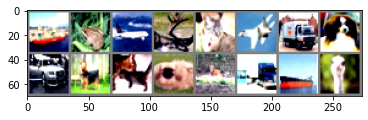

In [ ]:
# get some random training images
dataiter = iter(testloader)
images = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:16]))

8.**Evaluate your final model on the test set**

Submit `predictions.npy` to Gradescope to see your model's performance on the test set.

In [ ]:
# run inference on the test set
predictions = run_secret_test(testloader, net, IS_GPU)
# save predictions
predictions = np.asarray(predictions)
np.save("Q1_label_predictions.npy", predictions)

#**Q2: Surface normal estimation**

In this part, you will build your own surface normal estimation model on a  subset of the Taskonomy dataset. This task comprises of predicting the normal vector at every pixel location. We will be using the mean and median angular error as well as accuracy at 11.25$^{o}, 22.5^{o}, 30.0^{o}$ to measure performance. We provide code for computing these metrics.

In [ ]:
!pwd

/content/gdrive/MyDrive/Colab Notebooks/CS_585_PS2


In [ ]:
from IPython.display import Image as show_image
show_image(filename='/content/point_1_view_6_domain_rgb.png') 

FileNotFoundError: ignored

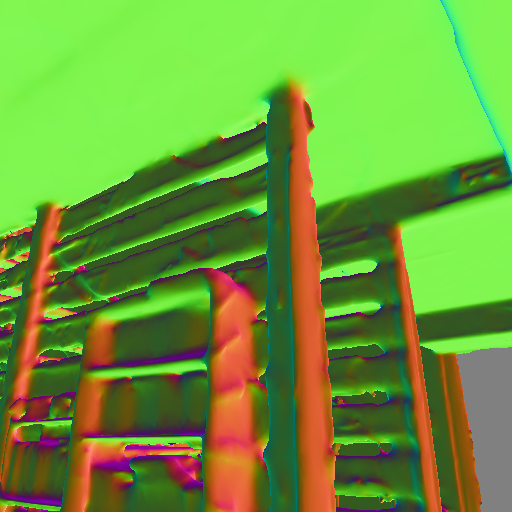

In [ ]:
show_image(filename='/content/point_1_view_6_domain_normal.png')

Data. We have 400 images for training, and 200 images for testing. Each image is 128x128. We provide a basic data loader that you can build upon.

Download the data (taskonomy_resize_128_release.zip) from google drive using this link (https://drive.google.com/file/d/1Y0ikK7f4-C3WYqi6UcdjRI2gwlU3pGGH/view?usp=sharing) and upload it to colab.



In [ ]:
!unzip -qqo /content/taskonomy_resize_128_release.zip

In [ ]:
import glob
import os
import numpy as np
import random
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchvision import models
from torchvision.transforms import ToTensor, Normalize

In [ ]:
# global variable
device = torch.device("cuda:0")

In [ ]:
class NormalDataset(data.Dataset):
    """
    Data loader for the Suface Normal Dataset. If data loading is a bottleneck, 
    you may want to optimize this in for faster training. Possibilities include
    pre-loading all images and annotations into memory before training, so as 
    to limit delays due to disk reads.
    """
    def __init__(self, split="train", data_dir="./taskonomy_resize_128_release"):
        assert(split in ["train", "val"])
        split2name = {
            "train": "allensville",
            "val": "beechwood",
        }
        self.img_dir = os.path.join(data_dir, split2name[split] + "_rgb")
        self.gt_dir = os.path.join(data_dir, split2name[split] + "_normal")
        
        self.split = split
        self.filenames = [
            os.path.splitext(os.path.basename(l))[0] for l in glob.glob(self.img_dir + "/*.png")
        ]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        filename = self.filenames[index]
        img = Image.open(os.path.join(self.img_dir, filename) + ".png")
        img = np.asarray(img).copy()
        gt = Image.open(os.path.join(self.gt_dir, filename.replace("_rgb", "_normal")) + ".png")
        gt = np.asarray(gt)

        # from rgb image to surface normal
        gt = gt.astype(np.float32) / 255
        gt = torch.Tensor(np.asarray(gt).copy()).permute((2, 0, 1))
        mask = self.build_mask(gt).to(torch.float)

        img = ToTensor()(img)
        img = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)

        # normalize gt
        gt = gt * 2 - 1
        
        return img.contiguous(), gt, mask.sum(dim=0) > 0

    @staticmethod
    def build_mask(target, val=0.502, tol=1e-3):
        target = target.unsqueeze(0)
        if target.shape[1] == 1:
            mask = ((target >= val - tol) & (target <= val + tol))
            mask = F.conv2d(mask.float(), torch.ones(1, 1, 5, 5, device=mask.device), padding=2) != 0
            return (~mask).expand_as(target).squeeze(0)

        mask1 = (target[:, 0, :, :] >= val - tol) & (target[:, 0, :, :] <= val + tol)
        mask2 = (target[:, 1, :, :] >= val - tol) & (target[:, 1, :, :] <= val + tol)
        mask3 = (target[:, 2, :, :] >= val - tol) & (target[:, 2, :, :] <= val + tol)
        mask = (mask1 & mask2 & mask3).unsqueeze(1)
        mask = F.conv2d(mask.float(), torch.ones(1, 1, 5, 5, device=mask.device), padding=2) != 0
        return (~mask).expand_as(target).squeeze(0)

Build on top of ImageNet pre-trained Model [15 pts]: Once you have a training cycle set up, you should design models for solving the task. To make training faster, we will build a model on top of a ResNet-18 1 model that has been pre-trained on the ImageNet dataset (via models.resnet18(pretrained=True)). These models are trained to predict the 1000 ImageNet object classes. To use this model for surface normal estimation, you will have to remove the classifier and global average pooling layers, and stack on additional layers for surface normal estimation. Note that, ResNet-18 model downsamples the input image by a factor of 32, remeber to upsample your prediction using bilinear interpolation. Since surface normal estimation is not a classification task anymore, you should also play with the loss function. Example of loss functions that you can try are: L1 loss, cosine similarity loss. You can refer to 2 3 for inspiration for how you can build on top of such pre-existing models. Again, carefully document the design choices you make in your report.

For reference, we provide the results obtained from a very simple model.

In [ ]:
show_image(filename='/content/baseline_result.png')

FileNotFoundError: ignored

In [ ]:
##########
#TODO: design your own network here. The expectation is to write from scratch. But it's okay to get some inspiration 
#from conference paper. The bottom line is that you will not just copy code from other repo
##########

import torch
import torch.nn as nn
import torchvision.models as models

class ResidualBlock(nn.Module):
    def __init__(self, input_planes, planes, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.red = nn.Sequential()
        if stride != 1 or input_planes != planes:
            self.red = nn.Sequential(
                nn.Conv2d(input_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out=self.conv1(x)
        out=self.bn1(out)
        out=F.relu(out)
        out= self.conv2(out)
        out = self.bn2(out)
        out += self.red(x)
        #out = F.relu(out)
        return out

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x1, x2):
        x1 = self.upconv(x1)
        #print(x1.shape,'hi')
        x1 = torch.cat([x1, x2], dim=1)
        x1 = self.conv1(x1)
        x1 = self.bn1(x1)
        x1 = self.relu1(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        x1 = self.relu2(x1)
        return x1


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.encoder = models.resnet18(pretrained=True)
        self.modules = list(self.encoder.children())[:-2]
        self.model2 = nn.Sequential(*self.modules)
        self.conv1 = nn.Sequential(self.encoder.conv1,
                                   self.encoder.bn1,
                                   self.encoder.relu)
        self.pool1 = self.encoder.maxpool
        self.layer1 = self.encoder.layer1
        self.layer2 = self.encoder.layer2
        self.layer3 = self.encoder.layer3
        self.layer4 = self.encoder.layer4

        self.upconv4 = UpConv(512, 256)
        self.upconv3 = UpConv(256, 128)
        self.upconv2 = UpConv(128, 64) 
        self.upconv10 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.rconv1 = ResidualBlock(64,32)
        self.upconv11 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
        self.rconv2 = ResidualBlock(32,3)

    def forward(self, x):
        x_new=self.model2(x)
        x1 = self.conv1(x)
        x2 = self.pool1(x1)
        x3 = self.layer1(x2)
        x4 = self.layer2(x3)
        x5 = self.layer3(x4)
        x6 = self.layer4(x5)

        x_ret = self.upconv4(x_new, x5)
        x_ret = self.upconv3(x_ret, x4)
        x_ret = self.upconv2(x_ret, x3)
        x_ret = self.upconv10(x_ret)
        x_ret = self.rconv1(x_ret)
        x_ret = self.upconv11(x_ret)
        x_ret = self.rconv2(x_ret)

        return x_ret
# Create an instance of the nn.module class defined above:
net = MyModel()

# Test your BaseNet with some random input
dummy_input = torch.rand((1, 3, 128, 128))
output = net(dummy_input)
#assert output.shape == torch.Size([1, 10])

# For training on GPU, we need to transfer net and data onto the GPU
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
if IS_GPU:
    net = net.cuda()


In [ ]:
print(net)

MyModel(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [ ]:
##########
#TODO: define your loss function here
##########


class MyCriterion(nn.Module):
    def __init__(self):
        super(MyCriterion, self).__init__()

    def forward(self, prediction, target, mask):
        l1_loss = nn.L1Loss()

        masked_l1_loss = ((l1_loss(prediction, target))* mask).unsqueeze(1)

        loss = masked_l1_loss.mean()
        return loss



In [ ]:
def simple_train(model, criterion, optimizer, train_dataloader, epoch, **kwargs):
    model.train()
    # TODO: implement your train loop here
    running_loss=0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs
        img, gt, mask= data
        img = img.to(device)
        gt = gt.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()

        outputs = model(img)
        loss = criterion(outputs,gt,mask)
        #loss.requires_grad = True
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    running_loss/=len(train_dataloader)
    print('[%d] loss: %.3f' %(epoch + 1, running_loss))


In [ ]:
def angle_error(prediction, target):
    prediction_error = torch.cosine_similarity(prediction, target)
    prediction_error = torch.clamp(prediction_error, min=-1.0, max=1.0)
    prediction_error = torch.acos(prediction_error) * 180.0 / np.pi
    return prediction_error

def simple_predict(split, model):
    model.eval()
    dataset = NormalDataset(split=split)
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, 
                                 num_workers=2, drop_last=False)
    gts, preds, losses = [], [], []
    total_normal_errors = None
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            img, gt, mask = batch
            img = img.to(device)
            gt = gt.to(device)
            mask = mask.to(device)

            pred = model(img)
            loss = (F.l1_loss(pred, gt, reduction="none") * mask.unsqueeze(1)).mean()

            gts.append((gt[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)
            preds.append((pred[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)
            losses.append(loss.item())

            angle_error_prediction = angle_error(pred, gt)
            angle_error_prediction = angle_error_prediction[mask > 0].view(-1)
            if total_normal_errors is None:
                total_normal_errors = angle_error_prediction.cpu().numpy()
            else:
                total_normal_errors = np.concatenate(
                    (total_normal_errors, angle_error_prediction.cpu().numpy())
                )

    return gts, preds, losses, total_normal_errors

In [ ]:
########################################################################
# TODO: Implement your training cycles, make sure you evaluate on validation 
# dataset and compute evaluation metrics every so often. 
# You may also want to save models that perform well.

model = MyModel().to(device)
criterion = MyCriterion().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
train_dataset = NormalDataset(split='train')
val_dataset= NormalDataset(split='val')
train_dataloader = data.DataLoader(train_dataset, batch_size=8, 
                                    shuffle=True, num_workers=2, 
                                    drop_last=True)
num_epochs = 100
for epoch in range(num_epochs):
    simple_train(model, criterion, optimizer, train_dataloader, epoch)
    val_gts, val_preds, val_losses, val_total_normal_errors = simple_predict('val', model)
    print("Validation loss (L1):", np.mean(val_losses))



[1] loss: 0.460


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.36064502090215683
[2] loss: 0.316


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.3287609914690256
[3] loss: 0.284


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.30876917950809
[4] loss: 0.268


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.3032315128669143
[5] loss: 0.259


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2949322780966759
[6] loss: 0.253


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.29531977869570253
[7] loss: 0.245


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.29029175996780393
[8] loss: 0.234


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2806757819652557
[9] loss: 0.222


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2755270583555102
[10] loss: 0.212


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2736394051462412
[11] loss: 0.204


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.27204119503498075
[12] loss: 0.196


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.26797401640564206
[13] loss: 0.187


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.26944779988378287
[14] loss: 0.185


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2720275381207466
[15] loss: 0.181


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.26341929759830235
[16] loss: 0.173


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.26284074660390616
[17] loss: 0.170


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.25649138804525135
[18] loss: 0.167


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.25671099349856374
[19] loss: 0.163


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2568554035946727
[20] loss: 0.160


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2613493402674794
[21] loss: 0.156


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2562918674200773
[22] loss: 0.156


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.25180043376982214
[23] loss: 0.152


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2537571001797915
[24] loss: 0.151


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2556628018990159
[25] loss: 0.151


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2522385239973664
[26] loss: 0.146


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.25123891662806275
[27] loss: 0.144


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2551913518458605
[28] loss: 0.144


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2501471887901425
[29] loss: 0.143


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.253778028935194
[30] loss: 0.140


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.25140685100108384
[31] loss: 0.140


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.25212900407612326
[32] loss: 0.136


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24595581490546464
[33] loss: 0.135


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2507669760286808
[34] loss: 0.134


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.25761398173868655
[35] loss: 0.135


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24995920609682798
[36] loss: 0.132


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24658101469278335
[37] loss: 0.131


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24756840713322162
[38] loss: 0.130


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2491536008939147
[39] loss: 0.130


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24636274691671134
[40] loss: 0.128


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24712045095860957
[41] loss: 0.127


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24561480727046728
[42] loss: 0.129


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24476656429469584
[43] loss: 0.127


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24919639516621828
[44] loss: 0.125


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24495326302945614
[45] loss: 0.124


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.25035213336348533
[46] loss: 0.124


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.25192261327058074
[47] loss: 0.126


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24781907092779876
[48] loss: 0.122


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24664455823600293
[49] loss: 0.120


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24436982113867997
[50] loss: 0.120


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24690745387226343
[51] loss: 0.122


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24653165001422167
[52] loss: 0.121


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24848140217363834
[53] loss: 0.119


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2495177388563752
[54] loss: 0.119


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24761027820408343
[55] loss: 0.118


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2444791016727686
[56] loss: 0.117


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24379819080233575
[57] loss: 0.117


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2460243422910571
[58] loss: 0.118


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24423758681863547
[59] loss: 0.116


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24687611971050502
[60] loss: 0.115


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24653172064572573
[61] loss: 0.116


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24773321244865656
[62] loss: 0.115


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24670515157282352
[63] loss: 0.114


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.247012774720788
[64] loss: 0.114


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2470332570001483
[65] loss: 0.114


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2455143439769745
[66] loss: 0.113


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2463425261899829
[67] loss: 0.112


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24739003326743841
[68] loss: 0.114


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24244867656379937
[69] loss: 0.112


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24637175478041173
[70] loss: 0.112


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24594220902770758
[71] loss: 0.111


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24395363856106997
[72] loss: 0.113


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2445964961871505
[73] loss: 0.110


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24431397244334221
[74] loss: 0.112


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2483322586491704
[75] loss: 0.109


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24758260168135166
[76] loss: 0.109


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2447474593669176
[77] loss: 0.110


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24841649785637857
[78] loss: 0.108


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24413945093750955
[79] loss: 0.109


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24660216499119997
[80] loss: 0.108


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2454782332852483
[81] loss: 0.110


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24476348578929902
[82] loss: 0.110


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2412006763741374
[83] loss: 0.107


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.25078752897679807
[84] loss: 0.107


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2464932358264923
[85] loss: 0.107


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24454419620335102
[86] loss: 0.107


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2448391257598996
[87] loss: 0.105


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24241067346185446
[88] loss: 0.107


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2425313650816679
[89] loss: 0.108


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24425862707197665
[90] loss: 0.104


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24705822778865694
[91] loss: 0.106


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24585958886891604
[92] loss: 0.105


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24415978603065014
[93] loss: 0.105


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2425482927635312
[94] loss: 0.105


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24454835694283247
[95] loss: 0.104


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24101985532790424
[96] loss: 0.106


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24397319853305816
[97] loss: 0.105


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24357907395809889
[98] loss: 0.104


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24161403208971025
[99] loss: 0.101


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2434391862899065
[100] loss: 0.103


  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24289866555482148


Increase your model output resolution [15 pts]: The current model simply replaces the final fully connected layer in a ResNet-18 model for surface normal estimation. This still has a lot of draw backs. The most important factors that causes poor performance is the low output resolution. ResNet-18 model for image classification downsamples the input image by a factor of 32. In the previous step, we recover the resolution by a simple bilinear interpolation layer which upsamples the prediction by 32 times. In this part, our goal is to explore other choices to generate high-resolution predictions. We offer two choices that you can consider: * Atrous (or dilated) convolution. The concept of atrous convolution (or dilated convolution) is described it the DeepLab paper4. One way to think about atrous convolution is to think of running the network on shifted versions of the image and weaving the outputs together to produce an output at the original spatial resolution. This can be done simply by using the dilataion arguments in PyTorch. Refer to the paper4 and PyTorch documentation for more detail. * Building a learned upsampler. Instead of using bilinear upsampling, you can use a decoder that learns to upsample prediction to improve the output quality. The key that makes decoder works better than bilinear interpolation is the usage of skip-connection. Refer to the U-net3 and DeepLabv3+5 for more detail.

You can implement either of these two choices, or other choices you
 find in other papers to increase your model output resolution. Please
 describe the methods you try in your report and report their
 performance.

 **In your report, include:**
- Your best model. Include final performance on validation set (5 metrics).
- An ablation table, listing all factors that you tried to make
  improvement to your final model as well as the validation performance.

# You do not need to change anything below

  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.24289866555482148
Validation metrics: Mean 31.8, Median 26.4, 11.25deg 23.3, 22.5deg 44.0, 30deg 55.3


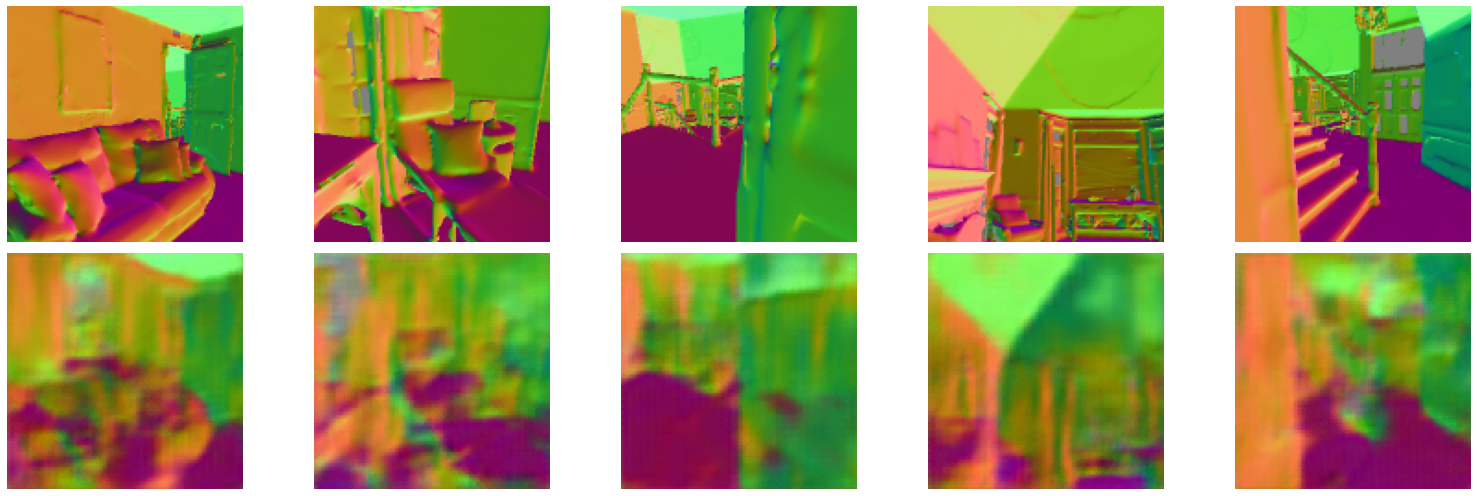

In [ ]:
########################################################################
# Evaluate your result, and report
# 1. Mean angular error
# 2. Median angular error
# 3. Accuracy at 11.25 degree
# 4. Accuracy at 22.5 degree
# 5. Accuracy at 30 degree
# using provided `simple_predict` function.

def angle_error(prediction, target):
    prediction_error = torch.cosine_similarity(prediction, target)
    prediction_error = torch.clamp(prediction_error, min=-1.0, max=1.0)
    prediction_error = torch.acos(prediction_error) * 180.0 / np.pi
    return prediction_error

def simple_predict(split, model):
    model.eval()
    dataset = NormalDataset(split=split)
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, 
                                 num_workers=2, drop_last=False)
    gts, preds, losses = [], [], []
    total_normal_errors = None
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            img, gt, mask = batch
            img = img.to(device)
            gt = gt.to(device)
            mask = mask.to(device)

            pred = model(img)
            loss = (F.l1_loss(pred, gt, reduction="none") * mask.unsqueeze(1)).mean()

            gts.append((gt[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)
            preds.append((pred[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)
            losses.append(loss.item())

            angle_error_prediction = angle_error(pred, gt)
            angle_error_prediction = angle_error_prediction[mask > 0].view(-1)
            if total_normal_errors is None:
                total_normal_errors = angle_error_prediction.cpu().numpy()
            else:
                total_normal_errors = np.concatenate(
                    (total_normal_errors, angle_error_prediction.cpu().numpy())
                )

    return gts, preds, losses, total_normal_errors

val_gts, val_preds, val_losses, val_total_normal_errors = simple_predict('val', model)
print("Validation loss (L1):", np.mean(val_losses))
print("Validation metrics: Mean %.1f, Median %.1f, 11.25deg %.1f, 22.5deg %.1f, 30deg %.1f" % (
    np.average(val_total_normal_errors), np.median(val_total_normal_errors),
    np.sum(val_total_normal_errors < 11.25) / val_total_normal_errors.shape[0] * 100,
    np.sum(val_total_normal_errors < 22.5) / val_total_normal_errors.shape[0] * 100,
    np.sum(val_total_normal_errors < 30) / val_total_normal_errors.shape[0] * 100
))

# vis validation
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(22, 7))
for idx, ax_i in enumerate(axs.T):
    ax = ax_i[0]
    ax.imshow(val_gts[idx])
    ax.axis('off')
    ax = ax_i[1]
    ax.imshow(val_preds[idx])
    ax.axis('off')
fig.tight_layout()
plt.savefig('vis_valset.pdf', format='pdf', bbox_inches='tight')

  0%|          | 0/200 [00:00<?, ?it/s]

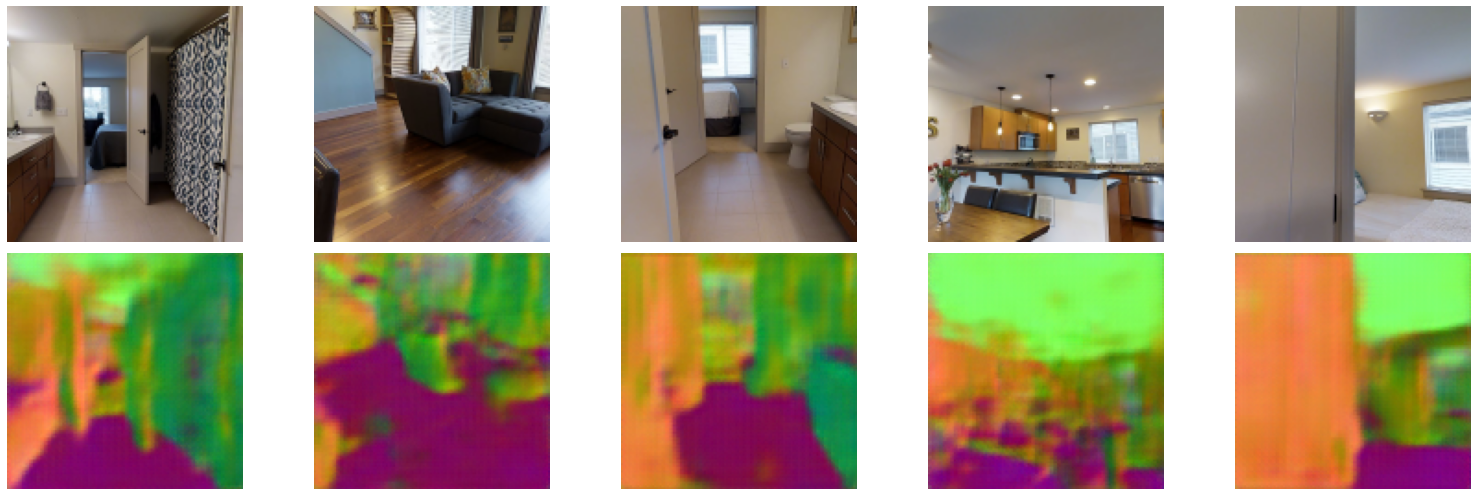

In [ ]:
# Visualization

class VisualizationDataset(data.Dataset):
    def __init__(self, image_dir="./taskonomy_resize_128_release", image_ext=".png"):
        self.img_dir = image_dir
        self.img_ext = image_ext

        self.img_dir = os.path.join(image_dir, "collierville_rgb") 
        
        self.image_filenames = [
            os.path.splitext(os.path.basename(l))[0] for l in glob.glob(self.img_dir + "/*" + image_ext)
        ]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        filename = self.image_filenames[index]
        img = Image.open(os.path.join(self.img_dir, filename) + self.img_ext)
        img = np.asarray(img).copy()
        img = ToTensor()(img)
        img = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)
        
        return img.contiguous(), filename

def simple_vis(model):
    model.eval()
    dataset = VisualizationDataset(image_dir="./taskonomy_resize_128_release")
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, 
                                 num_workers=2, drop_last=False)
    imgs, preds = [], []

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            img, _ = batch
            img = img.to(device)

            pred = model(img)
            imgs.append(
                std * img[0].permute((1, 2, 0)).cpu().numpy() + mean
            )
            preds.append((pred[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)

    return imgs, preds

imgs, preds = simple_vis(model)
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(22, 7))
for idx, ax_i in enumerate(axs.T):
    ax = ax_i[0]
    ax.imshow(imgs[idx])
    ax.axis('off')
    ax = ax_i[1]
    ax.imshow(preds[idx])
    ax.axis('off')
fig.tight_layout()
plt.savefig('q2_visualization.pdf', format='pdf', bbox_inches='tight')

Visualize your prediction [5 pts]: In your report, visualize 5 predictions of your model on images in the test set. 
**In your report, include:** 
- visualization of model prediction on five test images
- visual comparisons of the output from part 2 and 3 on 2 images from the 
  validation dataset, discuss your observations.

Test set [5 pts]. We have created a secret test set containing 200 images of indoor pictures from the collierville subset. We provide code that saves your model predictions to a Q2_normal_predictions file. Submit the prediction for your best model to gradescope.

In [ ]:
# Test your model on the test set, submit the output to gradescope

from PIL import Image
import numpy as np

def simple_test(model, out_dir):
    model.eval()
    dataset = VisualizationDataset(image_dir="./taskonomy_resize_128_release")
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, 
                                 num_workers=2, drop_last=False)

    saved_predictions = []
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            img, filename = batch
            img = img.to(device)

            pred = model(img)
            saved_predictions.append(pred.cpu())

        saved_predictions = torch.cat(saved_predictions, dim=0)
        return saved_predictions

out_dir = "Q2_normal_predictions"
saved_predictions = simple_test(model, out_dir)
np.save('./Q2_surface_predictions.npy', saved_predictions)

  0%|          | 0/200 [00:00<?, ?it/s]